In [1]:
import tensorflow as tf
import re
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from keras_tuner.tuners import RandomSearch
import numpy as np
import math
import pickle

# Prepare Corpus

In [41]:
df = pd.read_excel("Book1.xlsx")
df.head()

,text,label,username,social,time
0,"YEYYY CENTERRINDAHHH \nAku bangga sama kamu, a...",0,@Nhatha_lieL,X,2024-12-15T16:42:06.000Z
1,Yesssssss !!!!! Bagus bgt !!! ?????? Kids jama...,0,@khaty_lie,Threads,"Thursday, December 19, 2024 at 10:28 AM"
2,Yes yes yes..kirain lypsinc habisnya mirip sih...,0,@rereyazira,Threads,"Thursday, December 19, 2024 at 6:21 AM"
3,Yatuhan suaranyaaaaaaa bagus bangetttttttt,0,@ohmydull,X,2024-12-06T16:31:12.000Z
4,Ya ampun lakikny ganteng. Rini nya juga cantik...,0,@juannn____20,Threads,"Wednesday, December 18, 2024 at 11:57 AM"


# Preprocessing

In [42]:
def case_folding(text):
    return text.lower()

#NOISE REMOVAL
def noise_removal(text):
    #menghapus http / https
    text = re.sub(r'https?://\S+', '', text)
    #menghapus angka
    text = re.sub(r'(?<!\w)\b\d+\b(?!\w)', '', text)
    #menghapus special character
    text = re.sub(r'[^\w\s]', '', text)
    #menghapus spasi yang berlebihan
    text = re.sub(r'\s+', ' ', text).strip()
    return text

#SLANG WORD
slang_word_df = pd.read_csv("kamus_slangword.csv")
slang_dict = slang_word_df.set_index('slang')['formal'].to_dict()
def convert_to_formal(sentence):
    words = sentence.split()  # Split the sentence into words
    replaced_sentence = [slang_dict.get(word, word) for word in words]  # Replace slang with formal words
    return ' '.join(replaced_sentence)

#Stemming
stemmer = StemmerFactory().create_stemmer()

#Stopword Removal
stopper = StopWordRemoverFactory().create_stop_word_remover()

In [43]:
df['text'] = df['text'].apply(lambda text: stopper.remove(
        stemmer.stem(
            convert_to_formal(
                noise_removal(
                    case_folding(text)
                )
            )
        )
    ))

In [44]:
preprocessed_df = df[['text', 'label', 'username', 'social', 'time']]
preprocessed_df = preprocessed_df.drop_duplicates(subset=['text'], keep='last')

In [45]:
# Calculate the distribution of labels
label_distribution = preprocessed_df['label'].value_counts()
# Sort the distribution by label if needed
label_distribution = label_distribution.sort_index()
# Display the distribution
print(label_distribution)

label
0    100
1    100
2    100
3    100
Name: count, dtype: int64


# Data Splitting

In [46]:
shuffled_df = preprocessed_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_size = int(0.80 * len(shuffled_df))

train_df = shuffled_df.iloc[:train_size]
test_df = shuffled_df.iloc[train_size:]

train_text, train_label = train_df['text'].tolist(), train_df['label'].tolist()
test_text, test_label = test_df['text'].tolist(), test_df['label'].tolist()

In [47]:
# Count the occurrences of labels 0, 1, 2, and 3 in test_label
label_counts = test_df[test_df['label'].isin([0, 1, 2, 3])]['label'].value_counts()

# Optionally, print the counts for each label
print(label_counts)

label
3    23
2    20
0    19
1    18
Name: count, dtype: int64


# Tokenizing

In [9]:
oov_tok = "<OOV>"
trunc_type = 'post'

In [10]:
# Initialize and fit tokenizer
tokenizer = Tokenizer(num_words=1500, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)

In [35]:
print(tokenizer.word_index)
print(len(tokenizer.word_index))

{'<OOV>': 1, 'kamu': 2, 'aku': 3, 'lu': 4, 'sama': 5, 'orang': 6, 'sangat': 7, 'bangga': 8, 'anjing': 9, 'kalau': 10, 'jadi': 11, 'sih': 12, 'bodoh': 13, 'pengin': 14, 'otak': 15, 'kontol': 16, 'kasih': 17, 'nya': 18, 'fufufafa': 19, 'pimpin': 20, 'tidak': 21, 'dungu': 22, 'tolol': 23, 'bangsat': 24, 'kompeten': 25, 'terima': 26, 'buat': 27, 'anak': 28, 'mau': 29, 'apa': 30, 'emut': 31, 'semua': 32, 'hebat': 33, 'memang': 34, 'babi': 35, 'sukses': 36, 'selalu': 37, 'kayak': 38, 'mulyono': 39, 'nikmat': 40, 'najis': 41, 'miftah': 42, 'lihat': 43, 'telanjang': 44, 'ku': 45, 'syukur': 46, 'gus': 47, 'pakai': 48, 'tahu': 49, 'punya': 50, 'bapak': 51, 'begini': 52, 'kerja': 53, 'yang': 54, 'lebih': 55, 'perkosa': 56, 'remas': 57, 'banyak': 58, 'jangan': 59, 'bisa': 60, 'diri': 61, 'dulu': 62, 'hina': 63, 'di': 64, 'depan': 65, 'terus': 66, 'bukan': 67, 'sayang': 68, 'amin': 69, 'muka': 70, 'sepet': 71, 'cemen': 72, 'benar': 73, 'sini': 74, 'gua': 75, 'mana': 76, 'lo': 77, 'keren': 78, 'sala

In [37]:
with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Sequencing

In [12]:
# Convert text to sequences and pad them
train_sequences = tokenizer.texts_to_sequences(train_text)
test_sequences = tokenizer.texts_to_sequences(test_text)

# Padded Sequence

mean : 74.45
standar deviasi : 57.46117791534164
mean + std : 131.91117791534165
max : 346
Q3 : 94.0


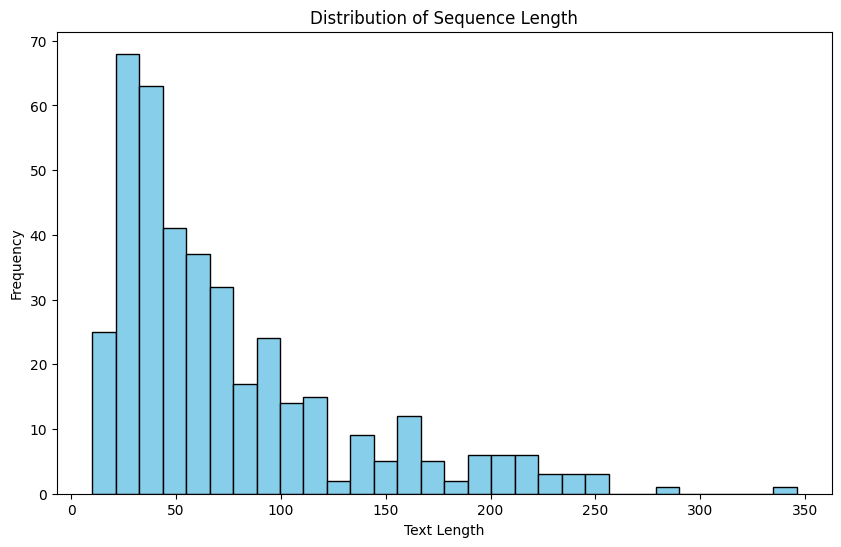

In [13]:
import matplotlib.pyplot as plt
preprocessed_df['text_length'] = preprocessed_df['text'].apply(len)
maximum_length = preprocessed_df['text_length'].max()
minimum_length = preprocessed_df['text_length'].min()
mean_length = preprocessed_df['text_length'].mean()
std_length = preprocessed_df['text_length'].std()
Q1 = preprocessed_df['text_length'].quantile(0.25)
Q2 = preprocessed_df['text_length'].quantile(0.50)
Q3 = preprocessed_df['text_length'].quantile(0.75)
print('mean : ' + str(mean_length))
print('standar deviasi : ' + str(std_length))
print('mean + std : ' + str(mean_length+std_length))
print('max : ' + str(maximum_length))
print('Q3 : '+ str(Q3))
text_length_distribution = preprocessed_df['text_length'].value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(preprocessed_df['text_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Sequence Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [14]:
max_padded_length = [ maximum_length, math.ceil(mean_length + std_length), math.ceil(Q3)]

In [15]:
train_padded = [1,2,3]
test_padded = [1,2,3]
for i in range (len(max_padded_length)):
    train_padded[i] = pad_sequences(train_sequences, maxlen=max_padded_length[i], truncating=trunc_type)
    test_padded[i] = pad_sequences(test_sequences, maxlen=max_padded_length[i], truncating=trunc_type)

# Hyperparameter Tuning

In [16]:
import random
def build_model(hp):
    model = tf.keras.Sequential()

    # Embedding layer
    model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index)+1, 
                                        output_dim=hp.Int('vector_dim', min_value=128, max_value=256, step=32)))
    
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        units=hp.Int('bilstm_dim', min_value=32, max_value=256, step=32),
    )))
    # Menentukan jumlah Dense Layer secara acak
    for i in range(hp.Int('num_dense_layers', 1, 3)):
        model.add(tf.keras.layers.Dense(units=hp.Int(f'dense_units_{i}', 32, 256, 32), activation='relu'))
        # Menambahkan Dropout secara opsional
        model.add(tf.keras.layers.Dropout(rate=hp.Float(f'dropout_rate_{i}', 0.2, 0.5, 0.1)))

    # Output layer
    model.add(tf.keras.layers.Dense(4, activation='softmax'))

    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [17]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

In [18]:
tuner0 = RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=1,
        directory='tuning_results0',
        project_name='tugas_akhir_hyperparameter_tuning'
    )
tuner0.search(train_padded[0], 
                np.array(train_label), 
                epochs=100, 
                batch_size=32,     # Batch size
                validation_split=0.2,
                callbacks=[early_stopping])

Reloading Tuner from tuning_results0/tugas_akhir_hyperparameter_tuning/tuner0.json


In [21]:
tuner1 = RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=1,
        directory='tuning_results1',
        project_name='tugas_akhir_hyperparameter_tuning'
    )

tuner1.search(train_padded[1], 
                np.array(train_label), 
                epochs=100, 
                batch_size=32,     # Batch size
                validation_split=0.2,
                callbacks=[early_stopping])

Trial 10 Complete [00h 01m 51s]
val_accuracy: 0.9375

Best val_accuracy So Far: 0.9375
Total elapsed time: 00h 08m 37s


In [20]:
tuner2 = RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=1,
        directory='tuning_results2',
        project_name='tugas_akhir_hyperparameter_tuning'
    )
tuner2.search(train_padded[2], 
                np.array(train_label), 
                epochs=100, 
                batch_size=32,     # Batch size
                validation_split=0.2,
                callbacks=[early_stopping])

Reloading Tuner from tuning_results2/tugas_akhir_hyperparameter_tuning/tuner0.json


In [22]:
import os
import json
import pandas as pd

# Path to the tuning results directory
tuning_results_dir = "tuning_results1/tugas_akhir_hyperparameter_tuning"

# Extract values for trials 00 to 09
trial_values = []
for i in range(10):
    trial_file = os.path.join(tuning_results_dir, f"trial_{i:02}/trial.json")
    if os.path.exists(trial_file):
        with open(trial_file, "r") as file:
            trial_data = json.load(file)
            trial_values.append({
                "trial": f"trial_{i:02}",
                "vector_dim": trial_data["hyperparameters"]["values"]["vector_dim"],
                "bilstm_dim": trial_data["hyperparameters"]["values"]["bilstm_dim"],
                "num_dense_layers": trial_data["hyperparameters"]["values"]["num_dense_layers"],
                "dense_units": [
                    trial_data["hyperparameters"]["values"].get(f"dense_units_{j}", None)
                    for j in range(trial_data["hyperparameters"]["values"]["num_dense_layers"])
                ],
                "dropout_rates": [
                    trial_data["hyperparameters"]["values"].get(f"dropout_rate_{j}", None)
                    for j in range(trial_data["hyperparameters"]["values"]["num_dense_layers"])
                ],
                "val_accuracy": trial_data["metrics"]["metrics"]["val_accuracy"]["observations"][0]["value"][0]
            })

# Convert to DataFrame
df_trials = pd.DataFrame(trial_values)
df_trials

,trial,vector_dim,bilstm_dim,num_dense_layers,dense_units,dropout_rates,val_accuracy
0,trial_00,192,192,2,"[96, 32]","[0.2, 0.2]",0.875000
1,trial_01,256,64,2,"[64, 192]","[0.30000000000000004, 0.2]",0.937500
2,trial_02,160,128,1,[32],[0.4],0.843750
3,trial_03,192,224,1,[224],[0.30000000000000004],0.875000
4,trial_04,128,64,1,[256],[0.30000000000000004],0.890625
5,trial_05,160,224,1,[32],[0.30000000000000004],0.937500
6,trial_06,128,96,2,"[128, 32]","[0.2, 0.30000000000000004]",0.937500
7,trial_07,160,64,3,"[160, 160, 32]","[0.30000000000000004, 0.4, 0.2]",0.921875
8,trial_08,160,160,2,"[192, 160]","[0.4, 0.4]",0.812500
9,trial_09,192,256,2,"[224, 32]","[0.4, 0.30000000000000004]",0.937500


# Building Model

In [23]:
vocab_size = len(tokenizer.word_index) + 1
padded_sequence_length = max_padded_length[1]
vector_dim = 256
bilstm_dim = 64
dense_dim1 = 64
dropout_val1 = 0.3
dense_dim2 = 192
dropout_val2 = 0.2

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=vector_dim, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(bilstm_dim)),
    tf.keras.layers.Dense(dense_dim1, activation='relu'),
    tf.keras.layers.Dropout(dropout_val1),
    tf.keras.layers.Dense(dense_dim2, activation='relu'),
    tf.keras.layers.Dropout(dropout_val2),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [35]:
model.build(input_shape=(None, padded_sequence_length))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 132, 100)       │       143,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 124)            │        80,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 192)            │        24,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 255,056 (996.31 KB)

 Trainable params: 255,056 (996.31 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
num_epochs = 100

In [26]:
history = model.fit(
    train_padded[1], 
    np.array(train_label), 
    epochs=num_epochs, 
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.2559 - loss: 1.3871 - val_accuracy: 0.1875 - val_loss: 1.3879
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.3297 - loss: 1.3705 - val_accuracy: 0.2969 - val_loss: 1.3657
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.5010 - loss: 1.3165 - val_accuracy: 0.5781 - val_loss: 1.2759
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.7555 - loss: 1.1391 - val_accuracy: 0.7656 - val_loss: 1.0005
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.7724 - loss: 0.8099 - val_accuracy: 0.8281 - val_loss: 0.6855
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.9032 - loss: 0.4536 - val_accuracy: 0.8125 - val_loss: 0.5742
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9544 - loss: 0.1972 - val_accuracy: 0.8906 - val_loss: 0.3923
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9932 - loss: 0.0499 - val_accuracy: 0.9531 - v

In [27]:
# Get the weights of the Embedding layer
embedding_layer = model.layers[0]  # Assuming Embedding is the first layer
embedding_weights = embedding_layer.get_weights()[0]

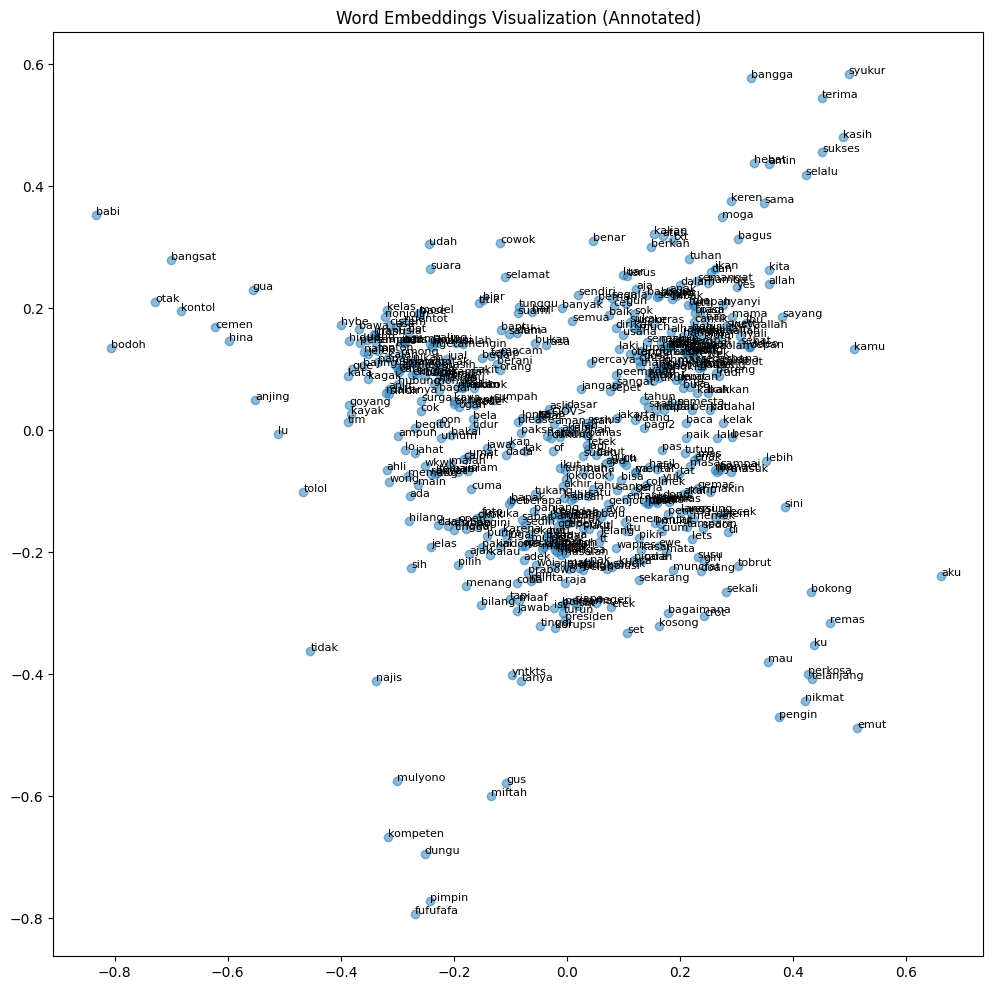

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_weights)

# Assuming you have a tokenizer with word_index mapping
word_index = tokenizer.word_index  # A dictionary mapping words to indices
index_word = {i: word for word, i in word_index.items()}  # Reverse mapping

# Plot with annotations
plt.figure(figsize=(12, 12))
for i in range(min(500, len(index_word))):  # Plot first 500 words
    word = index_word.get(i, None)
    if word:
        plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], word, fontsize=8)
plt.scatter(reduced_embeddings[:500, 0], reduced_embeddings[:500, 1], alpha=0.5)
plt.title("Word Embeddings Visualization (Annotated)")
plt.show()


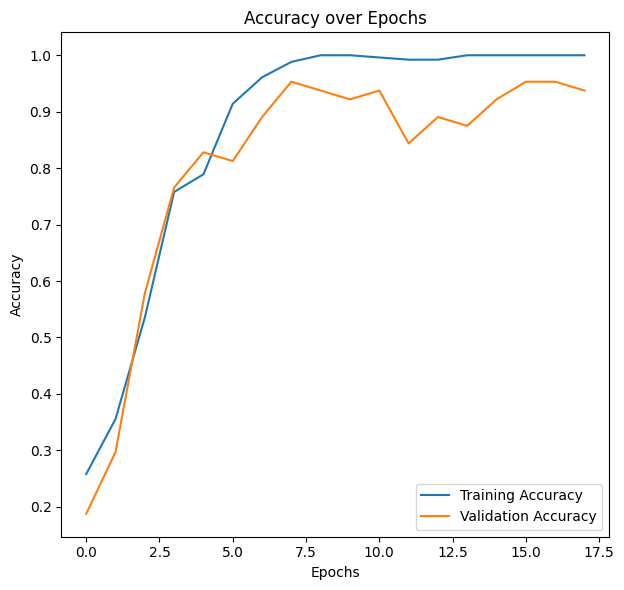

In [29]:
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

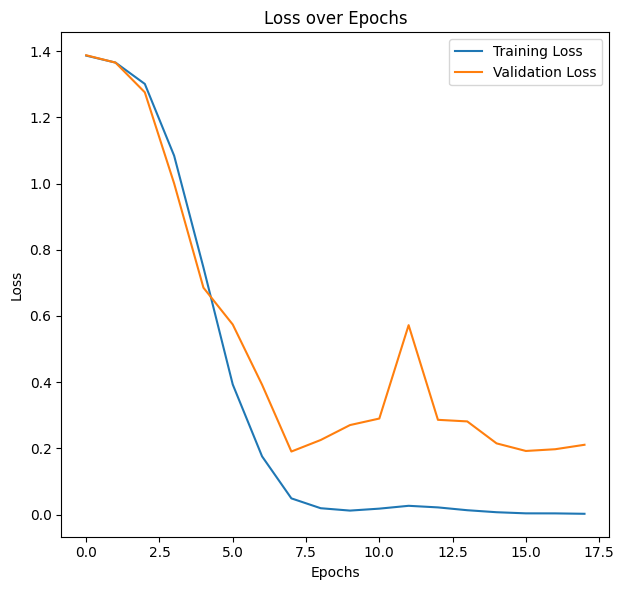

In [30]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on the test set
test_predictions = model.predict(test_padded[1])

# Convert probabilities to class labels
predicted_labels = np.argmax(test_predictions, axis=1)  # Choose the class with the highest probability

# Print the classification report
print(classification_report(test_label, predicted_labels, target_names=['0', '1', '2', '3']))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
              precision    recall  f1-score   support

           0       0.82      0.95      0.88        19
           1       0.94      0.89      0.91        18
           2       1.00      0.80      0.89        20
           3       0.92      1.00      0.96        23

    accuracy                           0.91        80
   macro avg       0.92      0.91      0.91        80
weighted avg       0.92      0.91      0.91        80



/opt/homebrew/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_8. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


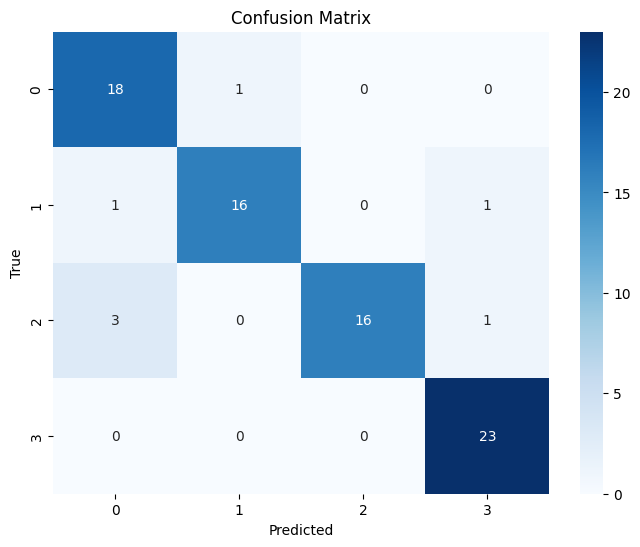

In [32]:
# Predict the test set
import seaborn as sns

test_predictions = model.predict(test_padded)
predicted_labels = np.argmax(test_predictions, axis=1)

# Generate confusion matrix
num_classes = 4  # Adjust based on the number of classes
cm = np.zeros((num_classes, num_classes), dtype=int)
for true_label, pred_label in zip(test_label, predicted_labels):
    cm[true_label][pred_label] += 1

# Create a Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [33]:
model.save('model.keras')